In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler




import warnings
warnings.filterwarnings('ignore')


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56']
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])





def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56



In [12]:
class MyResNetArgs:
       """Passing the hyperparameters to the model"""
       def __init__(self, arch='resnet20' ,epochs=50, start_epoch=0, batch_size=128, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
          
          self.save_every = save_every #Saves checkpoints at every specified number of epochs
          self.save_dir = save_dir #The directory used to save the trained models
          self.half = half #use half-precision(16-bit)
          self.evaluate = evaluate #evaluate model on the validation set
          self.pretrained = pretrained #evaluate the pretrained model on the validation set
          self.print_freq = print_freq #print frequency 
          self.weight_decay = weight_decay
          self.momentum = momentum 
          self.lr = lr #Learning rate
          self.batch_size = batch_size 
          self.start_epoch = start_epoch
          self.epochs = epochs
          self.arch = arch #ResNet model


In [22]:
from torchsummary import summary
args=MyResNetArgs('resnet20',pretrained=0)
#model = resnet.__dict__[args.arch]()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model =  globals()[args.arch]().to(device)
summary(model, (3,32,32))
best_prec1 = 0

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          432
├─BatchNorm2d: 1-2                       [-1, 16, 32, 32]          32
├─Sequential: 1-3                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-3                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-4             [-1, 16, 32, 32]          32
|    |    └─Sequential: 3-5              [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-7             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-8                  [-1, 16, 32, 32]          2,304
| 

In [14]:
from torchsummary import summary
args=MyResNetArgs('resnet32',pretrained=0)
#model = resnet.__dict__[args.arch]()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model =  globals()[args.arch]().to(device)
summary(model, (3,32,32))
best_prec1 = 0

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          432
├─BatchNorm2d: 1-2                       [-1, 16, 32, 32]          32
├─Sequential: 1-3                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-3                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-4             [-1, 16, 32, 32]          32
|    |    └─Sequential: 3-5              [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-7             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-8                  [-1, 16, 32, 32]          2,304
| 

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))




In [17]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)


In [18]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


           ship             cat           horse             car           truck           truck             car             cat


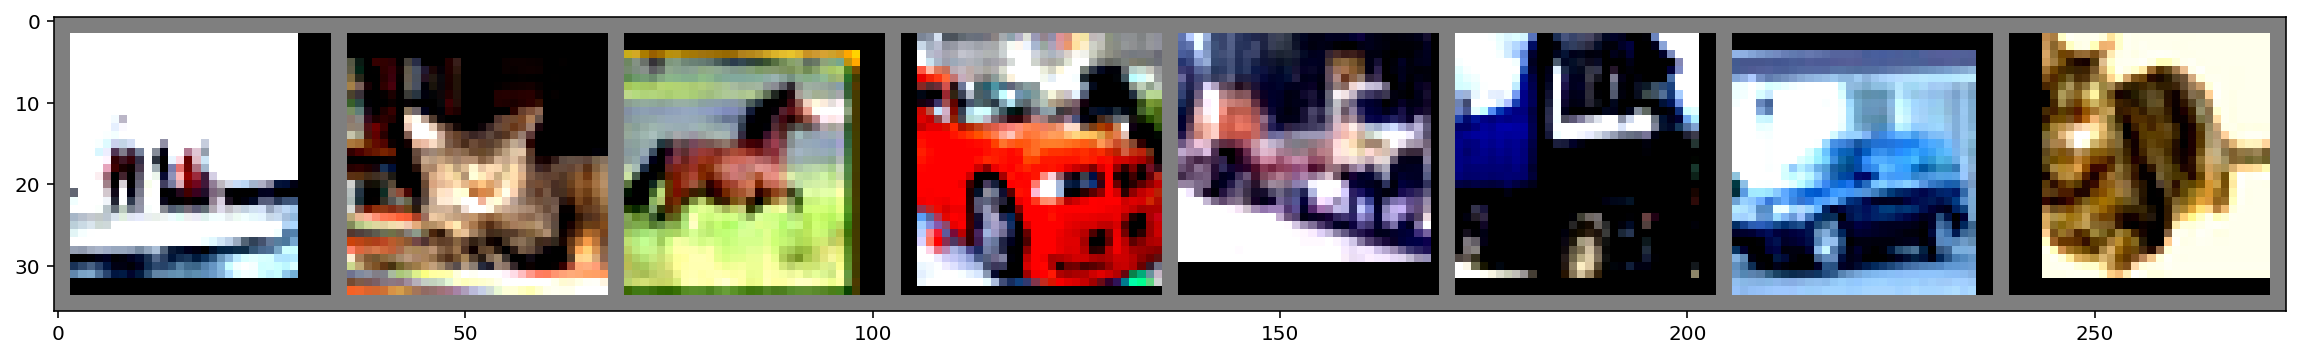

In [6]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))


In [20]:
import time

def main():
    global args, best_prec1
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model =  globals()[args.arch]().to(device)
    model.cuda()

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        print('half persicion is used.')
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)

    if args.arch in ['resnet1202']:
        # for resnet1202 original paper uses lr=0.01 for first 400 minibatches for warm-up
        # then switch back. In this setup it will correspond for first epoch.
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr*0.1


    if args.evaluate:
        print('evalution mode')
        model.load_state_dict(torch.load(os.path.join(args.save_dir, 'model.th')))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    if args.pretrained:
        print('evalution of pretrained model')
        args.save_dir='pretrained_models'
        pretrained_model= args.arch +'.th'
        model.load_state_dict(torch.load(os.path.join(args.save_dir, pretrained_model)))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        print('Training {} model'.format(args.arch))
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
        if is_best:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))

    return best_prec1

In [23]:
if __name__ == '__main__': 
    best_prec1 = main()
    print('The lowest error from {} model after {} epochs is {error:.3f}'.format(args.arch,args.epochs,error=100-best_prec1)) 

Training resnet20 model
current lr 1.00000e-01
Epoch: [0][0/391]	Loss 3.5689 (3.5689)	Prec@1 7.031 (7.031)
Epoch: [0][55/391]	Loss 1.8030 (2.1498)	Prec@1 36.719 (23.521)
Epoch: [0][110/391]	Loss 1.7471 (1.9687)	Prec@1 37.500 (27.717)
Epoch: [0][165/391]	Loss 1.4042 (1.8601)	Prec@1 42.188 (31.208)
Epoch: [0][220/391]	Loss 1.4470 (1.7783)	Prec@1 48.438 (34.159)
Epoch: [0][275/391]	Loss 1.3513 (1.7172)	Prec@1 50.000 (36.450)
Epoch: [0][330/391]	Loss 1.4397 (1.6599)	Prec@1 46.875 (38.687)
Epoch: [0][385/391]	Loss 1.1727 (1.6140)	Prec@1 57.812 (40.459)
Test	  Prec@1: 46.470 (Err: 53.530 )

Training resnet20 model
current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.2773 (1.2773)	Prec@1 50.781 (50.781)
Epoch: [1][55/391]	Loss 1.3059 (1.2579)	Prec@1 47.656 (53.697)
Epoch: [1][110/391]	Loss 1.1017 (1.2219)	Prec@1 59.375 (55.279)
Epoch: [1][165/391]	Loss 1.0425 (1.1914)	Prec@1 57.812 (56.255)
Epoch: [1][220/391]	Loss 1.1828 (1.1725)	Prec@1 59.375 (56.999)
Epoch: [1][275/391]	Loss 1.2741 (1.1544)	Pre

In [ ]:
if __name__ == '__main__': 
    best_prec1 = main()
    args.arch = 'resnet32';
    print('The lowest error from {} model after {} epochs is {error:.3f}'.format( args.arch,args.epochs,error=100-best_prec1)) 

Training resnet32 model
current lr 1.00000e-01
Epoch: [0][0/391]	Loss 4.8126 (4.8126)	Prec@1 10.938 (10.938)
Epoch: [0][55/391]	Loss 2.0015 (3.2928)	Prec@1 22.656 (13.560)
Epoch: [0][110/391]	Loss 1.8453 (2.6238)	Prec@1 31.250 (19.264)
Epoch: [0][165/391]	Loss 1.7414 (2.3557)	Prec@1 35.938 (22.948)
Epoch: [0][220/391]	Loss 1.6716 (2.1945)	Prec@1 37.500 (26.057)
Epoch: [0][275/391]	Loss 1.7556 (2.0908)	Prec@1 33.594 (28.054)
Epoch: [0][330/391]	Loss 1.6340 (2.0123)	Prec@1 39.062 (30.060)
Epoch: [0][385/391]	Loss 1.5781 (1.9461)	Prec@1 40.625 (31.835)
Test	  Prec@1: 40.840 (Err: 59.160 )

Training resnet32 model
current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.4036 (1.4036)	Prec@1 49.219 (49.219)
Epoch: [1][55/391]	Loss 1.3088 (1.4894)	Prec@1 57.031 (44.587)
Epoch: [1][110/391]	Loss 1.4552 (1.4871)	Prec@1 46.875 (44.728)
Epoch: [1][165/391]	Loss 1.4664 (1.4694)	Prec@1 42.188 (45.628)
Epoch: [1][220/391]	Loss 1.5268 (1.4522)	Prec@1 46.094 (46.394)
Epoch: [1][275/391]	Loss 1.3794 (1.4371)	P

In [24]:
from torchsummary import summary
args=MyResNetArgs('resnet44',pretrained=0)
#model = resnet.__dict__[args.arch]()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model =  globals()[args.arch]().to(device)
summary(model, (3,32,32))
best_prec1 = 0

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          432
├─BatchNorm2d: 1-2                       [-1, 16, 32, 32]          32
├─Sequential: 1-3                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-3                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-4             [-1, 16, 32, 32]          32
|    |    └─Sequential: 3-5              [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-7             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-8                  [-1, 16, 32, 32]          2,304
| 

In [25]:
if __name__ == '__main__': 
    best_prec1 = main()
    args.arch = 'resnet44';
    print('The lowest error from {} model after {} epochs is {error:.3f}'.format( args.arch,args.epochs,error=100-best_prec1)) 

Training resnet44 model
current lr 1.00000e-01
Epoch: [0][0/391]	Loss 4.8021 (4.8021)	Prec@1 10.156 (10.156)
Epoch: [0][55/391]	Loss 2.2239 (2.8684)	Prec@1 10.156 (13.742)
Epoch: [0][110/391]	Loss 2.0390 (2.4984)	Prec@1 23.438 (16.990)
Epoch: [0][165/391]	Loss 1.9911 (2.3236)	Prec@1 24.219 (19.658)
Epoch: [0][220/391]	Loss 1.7376 (2.2007)	Prec@1 32.812 (22.607)
Epoch: [0][275/391]	Loss 1.8931 (2.1164)	Prec@1 32.031 (24.791)
Epoch: [0][330/391]	Loss 1.7547 (2.0475)	Prec@1 32.812 (26.770)
Epoch: [0][385/391]	Loss 1.7116 (1.9911)	Prec@1 43.750 (28.366)
Test	  Prec@1: 42.030 (Err: 57.970 )

Training resnet44 model
current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.6105 (1.6105)	Prec@1 34.375 (34.375)
Epoch: [1][55/391]	Loss 1.5858 (1.5602)	Prec@1 42.188 (42.983)
Epoch: [1][110/391]	Loss 1.3609 (1.5442)	Prec@1 53.906 (43.117)
Epoch: [1][165/391]	Loss 1.3607 (1.5230)	Prec@1 53.906 (43.901)
Epoch: [1][220/391]	Loss 1.3761 (1.4953)	Prec@1 49.219 (45.065)
Epoch: [1][275/391]	Loss 1.0935 (1.4653)	P

In [26]:
from torchsummary import summary
args=MyResNetArgs('resnet56',pretrained=0)
#model = resnet.__dict__[args.arch]()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model =  globals()[args.arch]().to(device)
summary(model, (3,32,32))
best_prec1 = 0

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          432
├─BatchNorm2d: 1-2                       [-1, 16, 32, 32]          32
├─Sequential: 1-3                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-3                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-4             [-1, 16, 32, 32]          32
|    |    └─Sequential: 3-5              [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-7             [-1, 16, 32, 32]          32
|    |    └─Conv2d: 3-8                  [-1, 16, 32, 32]          2,304
| 

In [27]:
if __name__ == '__main__': 
    best_prec1 = main()
    args.arch = 'resnet56';
    print('The lowest error from {} model after {} epochs is {error:.3f}'.format( args.arch,args.epochs,error=100-best_prec1)) 

Training resnet56 model
current lr 1.00000e-01
Epoch: [0][0/391]	Loss 6.0584 (6.0584)	Prec@1 12.500 (12.500)
Epoch: [0][55/391]	Loss 2.2840 (3.3470)	Prec@1 11.719 (11.691)
Epoch: [0][110/391]	Loss 2.2261 (2.8167)	Prec@1 10.156 (12.324)
Epoch: [0][165/391]	Loss 2.1303 (2.6186)	Prec@1 19.531 (13.578)
Epoch: [0][220/391]	Loss 2.0265 (2.4902)	Prec@1 26.562 (15.367)
Epoch: [0][275/391]	Loss 1.9590 (2.3996)	Prec@1 20.312 (16.667)
Epoch: [0][330/391]	Loss 1.9950 (2.3280)	Prec@1 26.562 (18.035)
Epoch: [0][385/391]	Loss 1.9009 (2.2683)	Prec@1 28.906 (19.379)
Test	  Prec@1: 23.250 (Err: 76.750 )

Training resnet56 model
current lr 1.00000e-01
Epoch: [1][0/391]	Loss 1.9612 (1.9612)	Prec@1 21.094 (21.094)
Epoch: [1][55/391]	Loss 1.8317 (1.8575)	Prec@1 28.906 (29.785)
Epoch: [1][110/391]	Loss 1.9071 (1.8169)	Prec@1 22.656 (31.292)
Epoch: [1][165/391]	Loss 1.8355 (1.7868)	Prec@1 28.125 (32.380)
Epoch: [1][220/391]	Loss 1.6024 (1.7593)	Prec@1 45.312 (33.686)
Epoch: [1][275/391]	Loss 1.6463 (1.7296)	P